In [1]:
import requests
import datetime
import time
import sys

In [2]:
class API:
    def __init__(self, time_out, sleep):
        self.time_out = time_out
        self.sleep = sleep
        
    def change_param(time_out, sleep):
        self.time_out = time_out
        self.sleep = sleep 
    
    def unit_timestamp(self, date_time):
        return time.mktime(date_time.timetuple())
    
    def get_response(self, method, *args):
        response = method(*args)
        if response != {}:
            return response
        seconds = time.time()
        while(response == {}):
            if time.time() - seconds > self.time_out:
                raise Exception("time_out time reached")
            time.sleep(self.sleep)
            response = method(*args)
        return response
    

In [3]:
class CoinGeckoAPI(API):
    base_api_path = "https://api.coingecko.com/api/v3/"
    def __init__(self, time_out=sys.maxsize, sleep=5):
        super().__init__(time_out, sleep)
    
    def request_price_market_cap_volume(self, date_time_from, date_time_to):
        endpoint = f"{self.base_api_path}coins/bitcoin/market_chart/range?vs_currency=usd&from={self.unit_timestamp(date_time_from)}&to={self.unit_timestamp(date_time_to)}"
        response = requests.get(endpoint)
        if response.status_code not in range(200, 299):
            return {}
        return response.json()
    
    def request_daily_price_market_cap_volume(self, year, month, day):
        date_time = datetime.datetime(year=year, month=month, day=day)
        return self.request_price_market_cap_volume(date_time, date_time+datetime.timedelta(days=1))
    
    def get_daily_price_market_cap_volume(self, year, month, day):
        return self.get_response(self.request_daily_price_market_cap_volume, year, month, day)
    
    def get_closing_prices(self, _date_time_from, _date_time_to, period):
        '''
        _date_time_to is inclusive
        '''
        if _date_time_from > _date_time_to:
            raise Exception("_date_time_to is bigger than _date_time_from")
        if period == 'day':
            date_time_from = datetime.datetime(year=_date_time_from.year, month=_date_time_from.month, day=_date_time_from.day)
            date_time_to = datetime.datetime(year=_date_time_to.year, month=_date_time_to.month, day=_date_time_to.day)
            prices = [(i,j) for i,j in self.get_response(self.request_price_market_cap_volume, date_time_from, date_time_to)['prices']]
        elif period == 'week':
            date_time_from = datetime.datetime(year=_date_time_from.year, month=_date_time_from.month, day=_date_time_from.day) + datetime.timedelta(days = 6 - datetime.date.weekday(_date_time_from))
            date_time_to = datetime.datetime(year=_date_time_to.year, month=_date_time_to.month, day=_date_time_to.day) + datetime.timedelta(days = 6 - datetime.date.weekday(_date_time_to))
            prices = [(i,j) for i,j in self.get_response(self.request_price_market_cap_volume, date_time_from, date_time_to)['prices'] if datetime.datetime.weekday(datetime.datetime.fromtimestamp(i/1000)) == 6]
        else:
            raise Exception("The only viable periods are day and week")
        result = [prices[0][1]]
        for i,j in prices:
            if datetime.datetime.fromtimestamp(i/1000).day == date_time_from.day and datetime.datetime.fromtimestamp(i/1000).month == date_time_from.month and datetime.datetime.fromtimestamp(i/1000).year == date_time_from.year:
                result[len(result)-1] = j
            else:
                date_time_from = datetime.datetime.fromtimestamp(i/1000)
                result.append(j)
        return result

            

In [4]:
class GlassnodeAPI(API):
    base_api_path = "https://api.glassnode.com/v1/"
    def __init__(self, key, time_out=sys.maxsize, sleep=5):
        super().__init__(time_out, sleep)
        self.key = key
        
    

In [5]:
glassnode_api_key = open("/home/malimi/Skillset/glassnode_api_key.txt",'r').read()[:-1]

In [6]:
g = GlassnodeAPI(key=glassnode_api_key)

In [7]:
import json
import pandas as pd

In [8]:
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr',
    params={'a': 'BTC', 'api_key': g.key})
df = pd.read_json(res.text, convert_dates=['t'])

In [9]:
df

,t,v
0,2010-07-17,1.000000
1,2010-07-18,1.174760
2,2010-07-19,1.318536
3,2010-07-20,1.090517
4,2010-07-21,1.065532
...,...,...
4216,2022-01-31,0.998668
4217,2022-02-01,1.016613
4218,2022-02-02,0.997679
4219,2022-02-03,0.997416


In [10]:
datetime.datetime.fromtimestamp(1612396800)

datetime.datetime(2021, 2, 4, 1, 0)

In [11]:
# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr',
    params={'a': 'BTC', 'api_key': g.key})

# convert to pandas dataframe
df = pd.read_json(res.text, convert_dates=['t'])

In [12]:
df = pd.read_json(requests.get('https://api.glassnode.com/v1/metrics/market/price_realized_usd',
    params={'a': 'BTC', 'api_key': g.key}).text)
df

,t,v
0,1230940800,0.049510
1,1231027200,NaN
2,1231113600,NaN
3,1231200000,NaN
4,1231286400,NaN
...,...,...
4411,1612051200,11921.776189
4412,1612137600,11945.138601
4413,1612224000,11999.467109
4414,1612310400,12052.611823


In [13]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df

,t,v
0,1230940800,0.049510
1,1231027200,NaN
2,1231113600,NaN
3,1231200000,NaN
4,1231286400,NaN
5,1231372800,NaN
6,1231459200,0.049510
7,1231545600,0.049510
8,1231632000,0.049510
9,1231718400,0.049510


In [15]:
date_time_from = datetime.datetime(year=2013, month=5,day=1)
date_time_to = datetime.datetime(year=2022, month = 2, day = 1)

In [16]:
len(CoinGeckoAPI().request_price_market_cap_volume(date_time_from,date_time_to)['prices'])

3196

In [17]:
y = CoinGeckoAPI().get_closing_prices(date_time_from,date_time_to,'day')

In [18]:
import matplotlib.pyplot as plt
import numpy as np

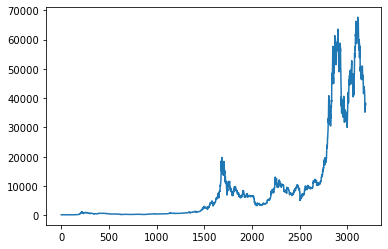

In [19]:
plt.plot(np.arange(len(y)),y);